In [1]:
from firedrake import *
from irksome import GaussLegendre, Dt, MeshConstant, TimeStepper
from IPython.display import HTML
import sys
from firedrake.pyplot import FunctionPlotter, tripcolor
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation


firedrake:WARNING OMP_NUM_THREADS is not set or is set to a value greater than 1, we suggest setting OMP_NUM_THREADS=1 to improve performance


In [2]:
mesh = UnitCubeMesh(10, 10, 10)

In [3]:
W = FunctionSpace(mesh, "N1E", 1)
X = FunctionSpace(mesh, "N1F", 1)

Q = W * X

In [4]:
x, y, z = SpatialCoordinate(mesh)

In [5]:
up0 = project(as_vector([sin(pi*z) * sin(pi*y) * cos(pi * y) * sin(pi * x) ** 2, - sin(pi*z) * sin(pi*x) * cos(pi * x) * sin(pi * y) ** 2, 0, 0, 0, 0]), Q)
E0, B0 = split(up0)
up_init = up0.copy(deepcopy=True)
DivE = inner(div(E0), div(E0))*dx
DivB = inner(div(B0), div(B0))*dx
print(sqrt(assemble(DivE)))

7.608715060947859e-15


In [6]:
F, C = TestFunctions(Q)
F = inner(Dt(E0), F) * dx- inner(B0, curl(F)) * dx + inner(Dt(B0), C) * dx + inner(curl(E0), C) * dx

In [7]:
EE = 0.5 * (inner(E0, E0)*dx)
EB = 0.5 * (inner(B0, B0)*dx)

In [8]:
ups = [up_init]
ts = [0.]
Es = [assemble(EE + EB)]
EeS = [assemble(EE)]
EbS = [assemble(EB)]
divBs = [sqrt(assemble(DivB))]
divEs = [sqrt(assemble(DivE))]

In [9]:
MC = MeshConstant(mesh)
t = MC.Constant(0.0)
dt = MC.Constant(1.0/100)

In [10]:
butcher_tableau = GaussLegendre(2)

In [11]:
Ebcs = DirichletBC(Q.sub(0), as_vector([0., 0., 0.]), [1, 2, 3, 4, 5, 6])
Bbcs = DirichletBC(Q.sub(1), as_vector([0., 0., 0.]), [1, 2, 3, 4, 5, 6])
bcs = [Ebcs, Bbcs]

In [12]:
params = {"mat_type": "aij",
          "snes_type": "ksponly",
          "ksp_type": "preonly",
          "pc_type": "lu"}

stepper = TimeStepper(F, butcher_tableau, t, dt, up0,
                      solver_parameters=params, bcs = bcs)

In [13]:
print("Time    Energy")
print("==============")

step = 0
output_freq = 1

while (float(t) < 3.):

    stepper.advance()

    t.assign(float(t) + float(dt))
    ts.append(float(t))
    Es.append(assemble(EE + EB))
    EeS.append(assemble(EE))
    EbS.append(assemble(EB))
    divBs.append(sqrt(assemble(DivB)))
    divEs.append(sqrt(assemble(DivE)))
    
    print("time: {0:5e} energy {1:5e}".format(float(t), Es[-1]))
    print("E field Energy: {0:5e} B field Energy {1:5e}".format(EeS[-1], EbS[-1]))
    print("div E:", divEs[-1])
    print("divB B:", divBs[-1])
    print()
        
    step += 1
    
    if step % output_freq == 0:
        ups.append(up0.copy(deepcopy=True))

Time    Energy
time: 1.000000e-02 energy 2.262142e-02
E field Energy: 2.247322e-02 B field Energy 1.481977e-04
div E: 7.531192298342869e-15
divB B: 5.909437235142538e-16

time: 2.000000e-02 energy 2.262142e-02
E field Energy: 2.204157e-02 B field Energy 5.798474e-04
div E: 7.36863928185459e-15
divB B: 7.148487347971563e-16

time: 3.000000e-02 energy 2.262142e-02
E field Energy: 2.135279e-02 B field Energy 1.268626e-03
div E: 7.252644617838246e-15
divB B: 8.943173120884325e-16

time: 4.000000e-02 energy 2.262142e-02
E field Energy: 2.042830e-02 B field Energy 2.193122e-03
div E: 7.20936272447443e-15
divB B: 1.1165154968374997e-15

time: 5.000000e-02 energy 2.262142e-02
E field Energy: 1.928463e-02 B field Energy 3.336792e-03
div E: 7.132967538540313e-15
divB B: 1.3656309758167813e-15

time: 6.000000e-02 energy 2.262142e-02
E field Energy: 1.794431e-02 B field Energy 4.677107e-03
div E: 6.9209215604148755e-15
divB B: 1.6147281804244299e-15

time: 7.000000e-02 energy 2.262142e-02
E field 

In [14]:
assemble(DivE)

4.9957303502792285e-29

In [15]:
type(assemble(DivE))

numpy.float64

Text(0.5, 0, 'Time')

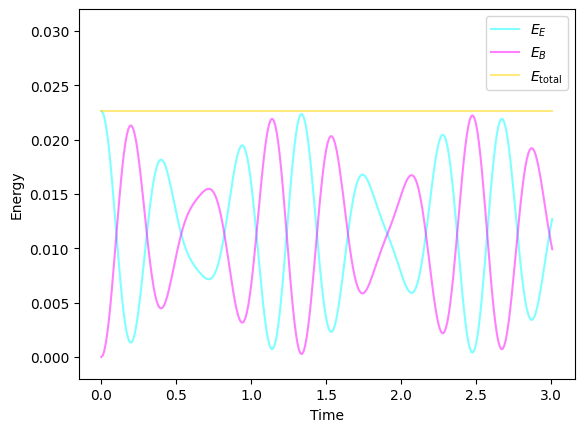

In [17]:
fig, ax = plt.subplots(1)
ax.plot(ts, EeS, c= "cyan", alpha = 0.5, label = "$E_{E}$")
ax.plot(ts, EbS, c = "magenta", alpha = 0.5, label = "$E_{B}$")
ax.plot(ts, Es, c = "gold", alpha = 0.5, label = "$E_{\\text{total}}$")
ax.legend()
ax.set_ylim(- 0.002, 0.032)
ax.set_ylabel("Energy")
ax.set_xlabel("Time")

In [18]:
fig.savefig("ElmagSimEnergy.png")

In [19]:
df = pd.DataFrame()
df["time"] = ts
df["Electric Field Energy"] = EeS
df["Magnetic Field Energy"] = EbS
df["Total Energy"] = Es
df["L2 divergence B"] = divBs
#df["L2 divergence E"] = divEs

In [20]:
df.to_csv("ElmagSimData.csv")

In [21]:
df

,time,Electric Field Energy,Magnetic Field Energy,Total Energy,L2 divergence B
0,0.00,0.022621,0.000000,0.022621,0.000000e+00
1,0.01,0.022473,0.000148,0.022621,5.909437e-16
2,0.02,0.022042,0.000580,0.022621,7.148487e-16
3,0.03,0.021353,0.001269,0.022621,8.943173e-16
4,0.04,0.020428,0.002193,0.022621,1.116515e-15
...,...,...,...,...,...
297,2.97,0.009499,0.013122,0.022621,8.983762e-15
298,2.98,0.010378,0.012243,0.022621,8.957769e-15
299,2.99,0.011214,0.011407,0.022621,8.963161e-15
300,3.00,0.011993,0.010628,0.022621,8.956376e-15
